# python垃圾回收机制

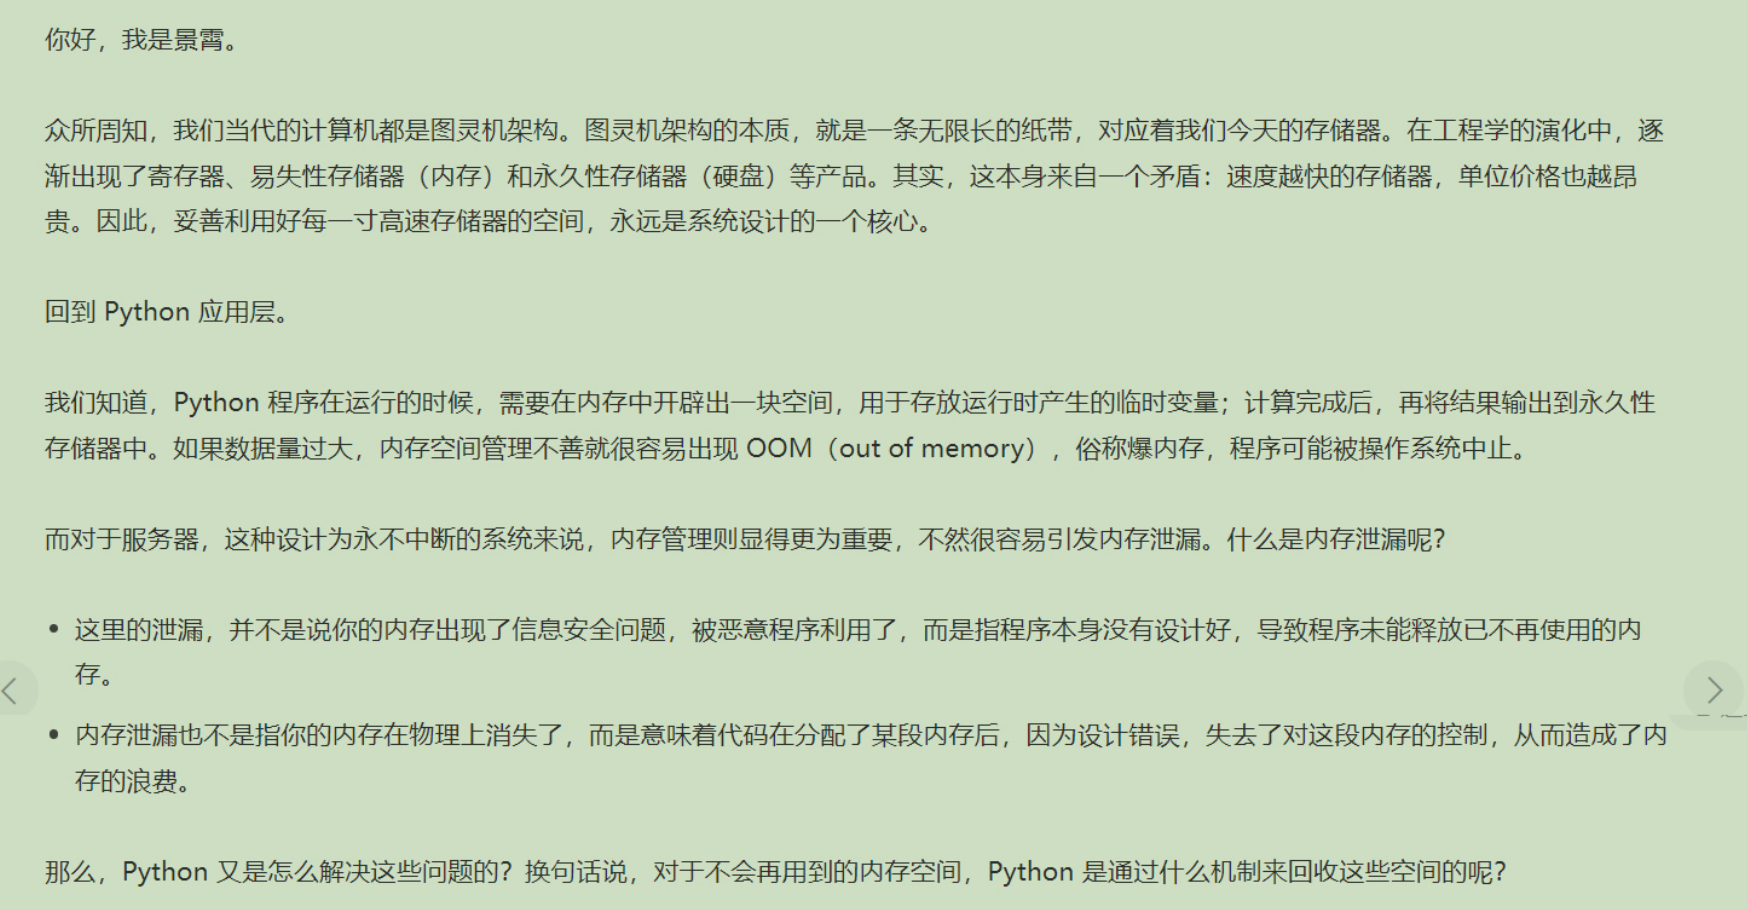

## 计数引用
Python中一切皆对象，因此，你所看到的一切变量，本质上都是对象的一个指针。

当这个对象的引用计数（指针数）为0的时候，说明这个对象永不可达，自然它也就成为了垃圾，需要被回收。

我们先看一个例子：

In [2]:
import os
import psutil

# 显示当前python程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)

    info = p.memory_full_info()
    memory = info.uss / 1024.0 / 1024
    print(f"{hint} memory used: {memory} MB")


def func():
    show_memory_info("initial")
    a = list(range(10000000))
    show_memory_info("after a created")


func()
show_memory_info("finished")

initial memory used: 65.18359375 MB
after a created memory used: 452.578125 MB
finished memory used: 65.52734375 MB


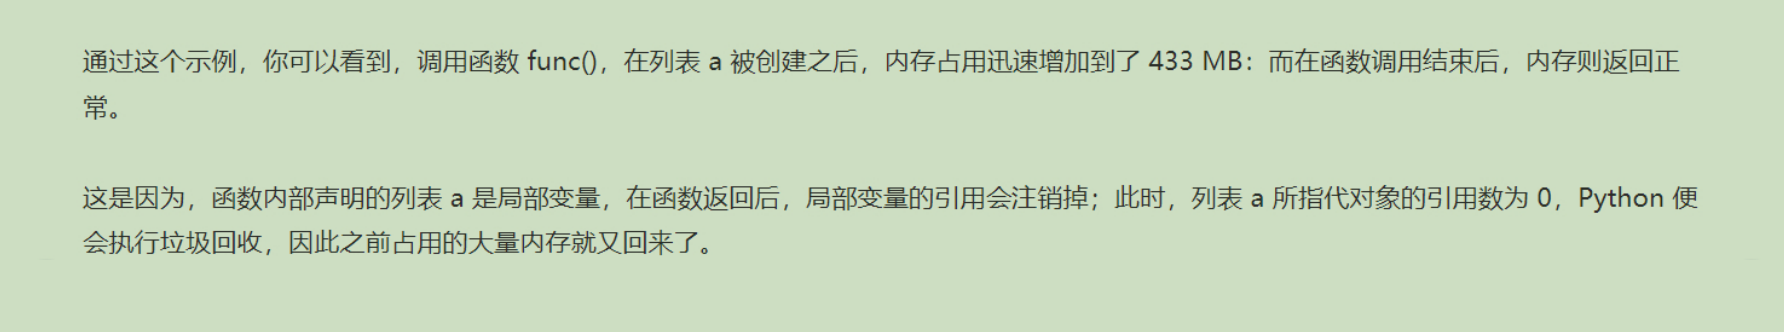

明白这个原理后，我们稍微修改一下代码：

In [2]:
import os
import psutil

# 显示当前python程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)

    info = p.memory_full_info()
    memory = info.uss / 1024.0 / 1024
    print(f"{hint} memory used: {memory} MB")


def func():
    show_memory_info("initial")
    global a
    a = list(range(10000000))
    show_memory_info("after a created")


func()
show_memory_info("finished")

initial memory used: 11.5078125 MB
after a created memory used: 399.5 MB
finished memory used: 399.5 MB


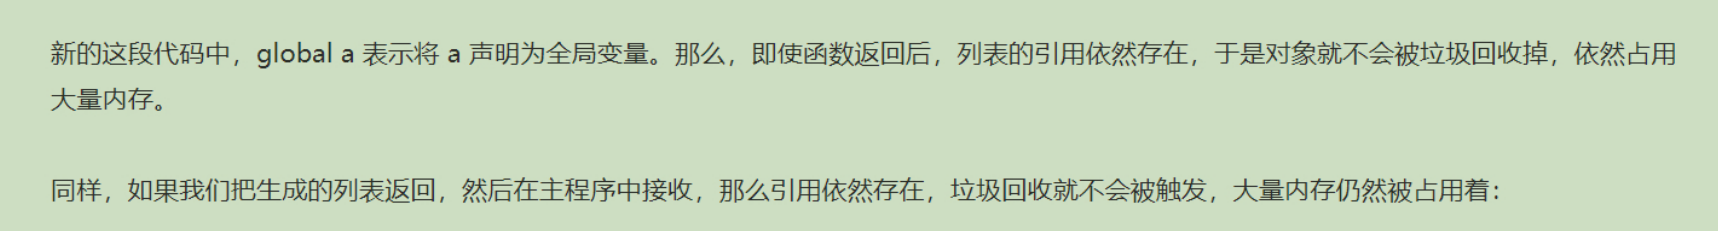

In [1]:
import os
import psutil

# 显示当前python程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)

    info = p.memory_full_info()
    memory = info.uss / 1024.0 / 1024
    print(f"{hint} memory used: {memory} MB")


def func():
    show_memory_info("initial")
    a = list(range(10000000))
    show_memory_info("after a created")
    return a


func()
show_memory_info("finished")

initial memory used: 51.1171875 MB
after a created memory used: 438.734375 MB
finished memory used: 51.68359375 MB


这是最常见的几种情况。由表及里，下面，我们深入看一下Python内部的引用计数规则。

In [1]:
import sys

a = []

# 两次引用，一次来自 a，一次来自getrefcount
print(sys.getrefcount(a))


def func(a):
    # 四次引用 a, python的函数调用栈，函数参数，和getrefcount
    print(sys.getrefcount(a))


func(a)

# 两次引用，一次来自a，一次来自getrefcount，函数func 调用已经不存在
print(sys.getrefcount(a))

2
4
2


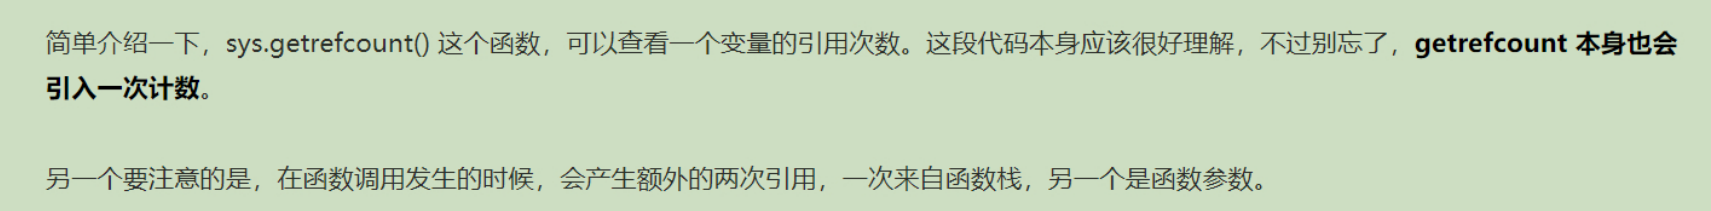

In [2]:
import sys

a = []

print(sys.getrefcount(a))  # * 两次

b = a

print(sys.getrefcount(a))  # * 三次

c = b
d = b
e = c
f = e
g = d

print(sys.getrefcount(a))  # * 八次

2
3
8


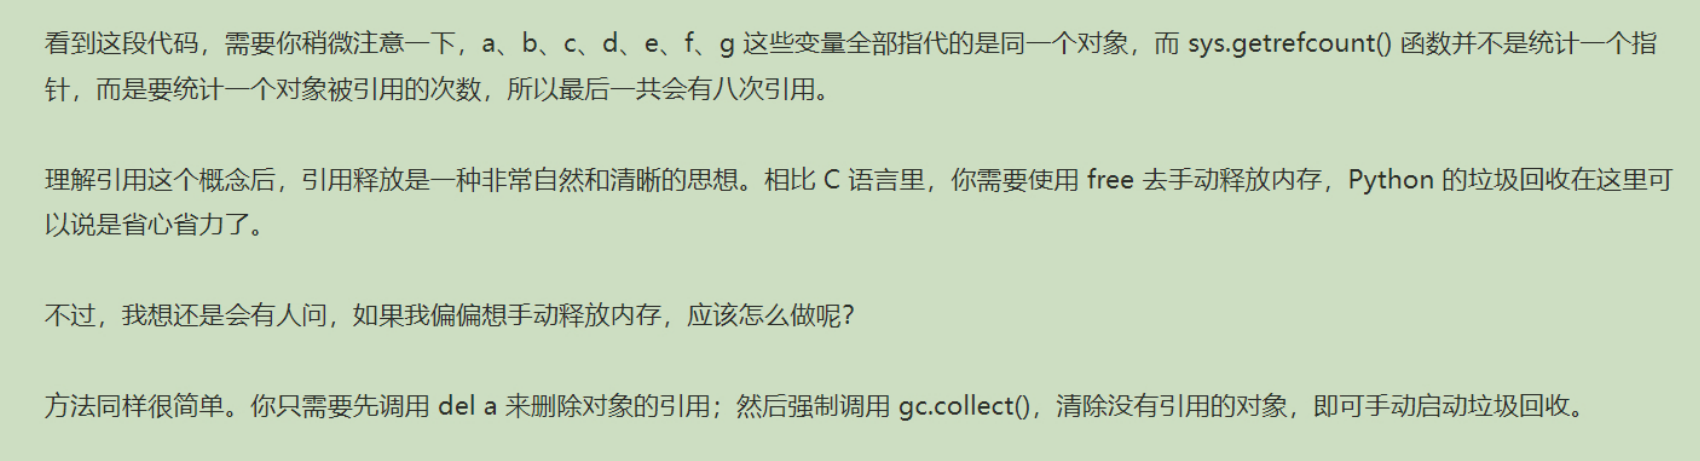

In [5]:
import gc

show_memory_info("initial")
a = list(range(10000000))
show_memory_info("after a created")

del a
gc.collect()
show_memory_info("finish")
print(a)

initial memory used: 59.27734375 MB
after a created memory used: 446.328125 MB
finish memory used: 59.27734375 MB


NameError: name 'a' is not defined

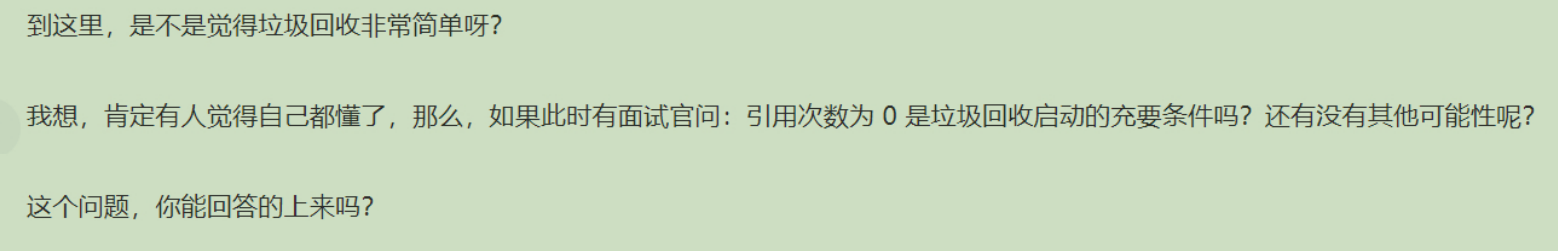

## 循环引用

如果有两个对象，他们互相引用，并且不再被别的对象所引用，那么它应该被垃圾回收吗？

In [3]:
def func():
    show_memory_info("initial")
    a = list(range(10000000))
    b = list(range(10000000))
    show_memory_info("after a,b created")
    a.append(b)
    b.append(a)


func()
show_memory_info("finished")

initial memory used: 65.53515625 MB
after a,b created memory used: 839.8828125 MB
finished memory used: 839.9453125 MB


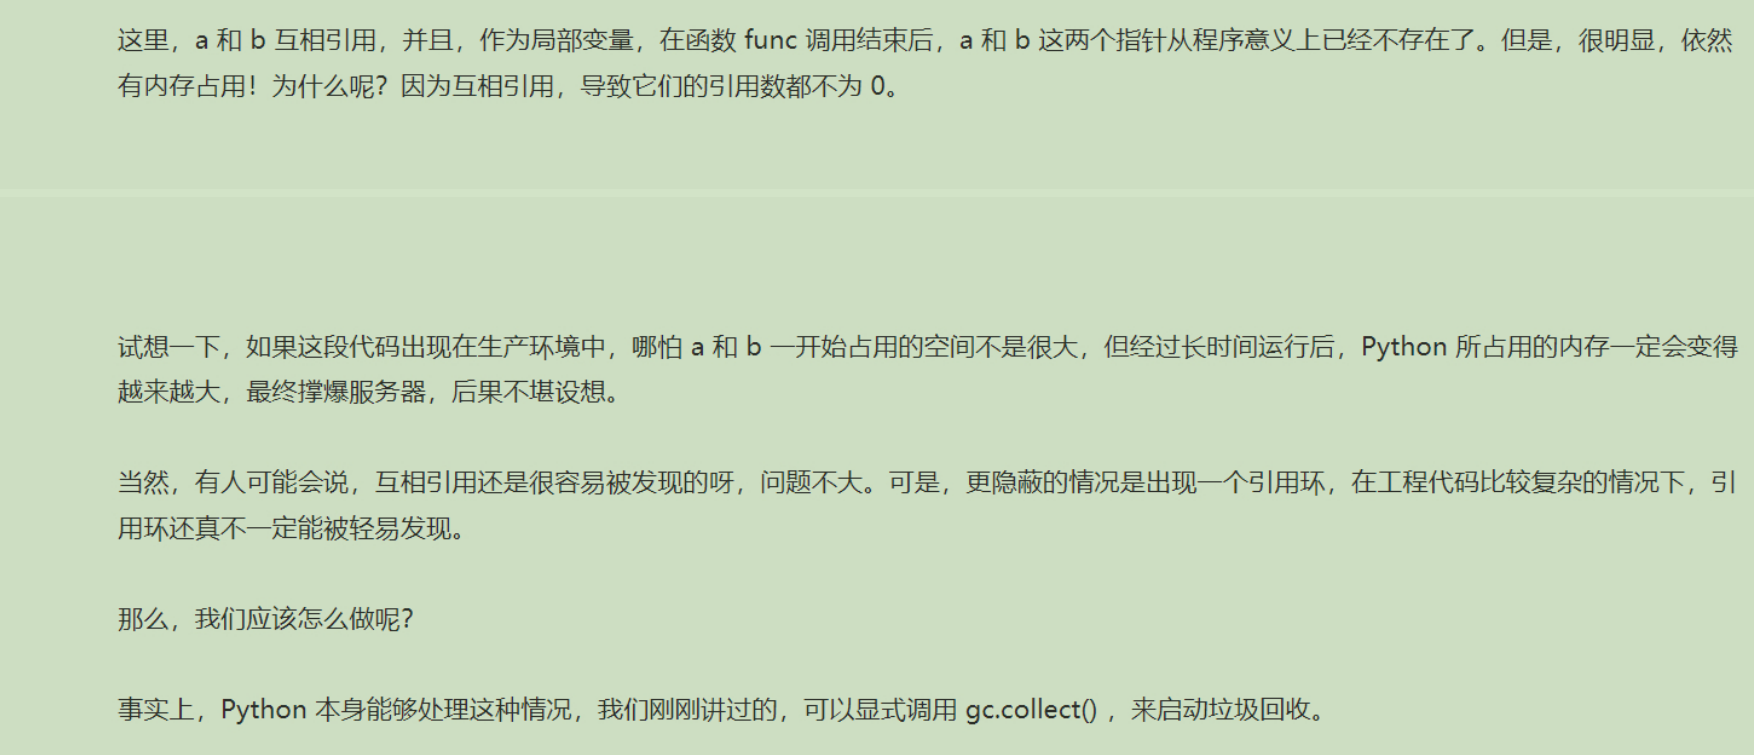

In [6]:
import gc


def func():
    show_memory_info("initial")
    a = list(range(10000000))
    b = list(range(10000000))
    show_memory_info("after a,b created")
    a.append(b)
    b.append(a)


func()
gc.collect()
show_memory_info("finished")

initial memory used: 66.109375 MB
after a,b created memory used: 839.98046875 MB
finished memory used: 65.8828125 MB


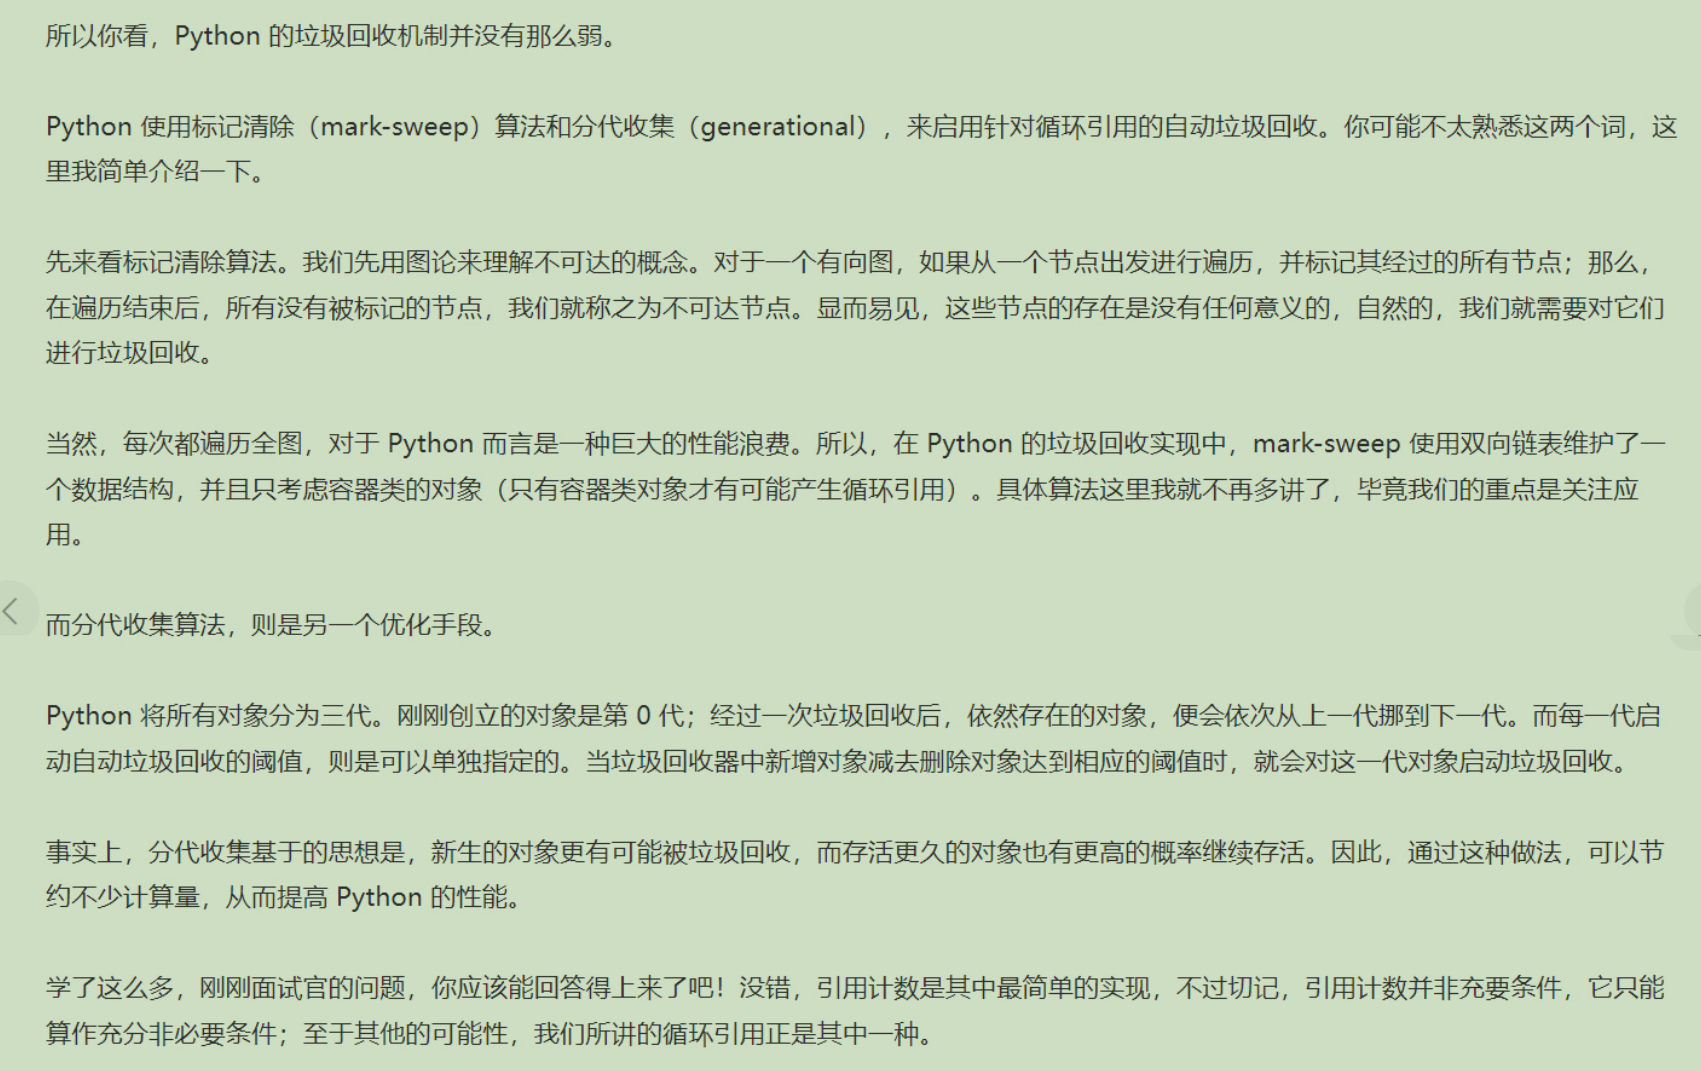

## 调试内存泄露

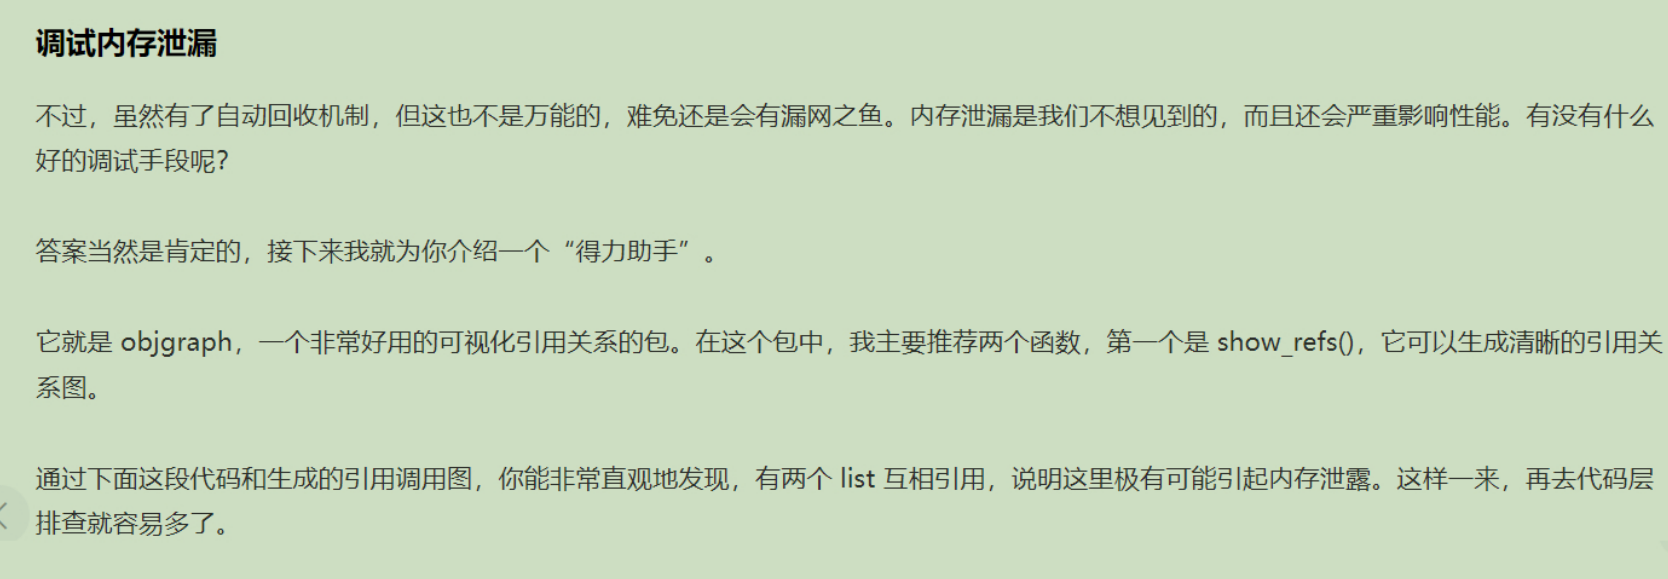

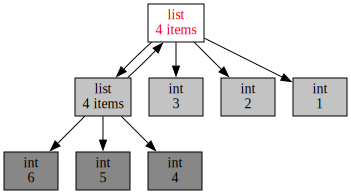

In [1]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_refs([a])

另一个非常有用的函数，是show_backrefs()。

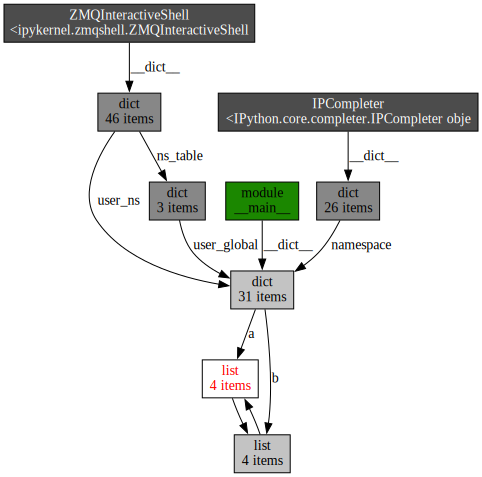

In [2]:
import objgraph

a = [1, 2, 3]
b = [4, 5, 6]

a.append(b)
b.append(a)

objgraph.show_backrefs([a])

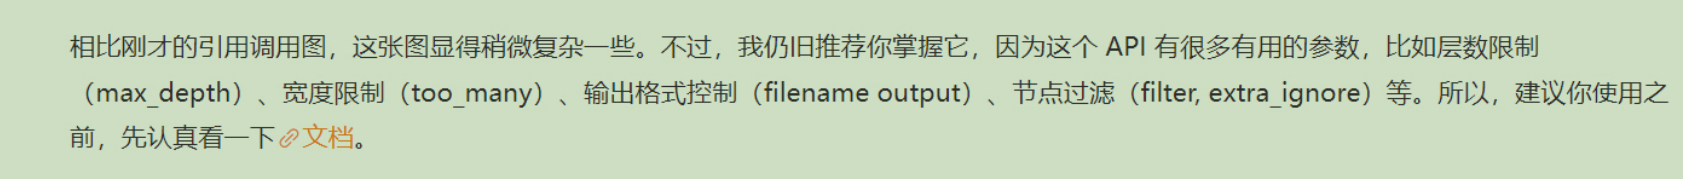

## 总结

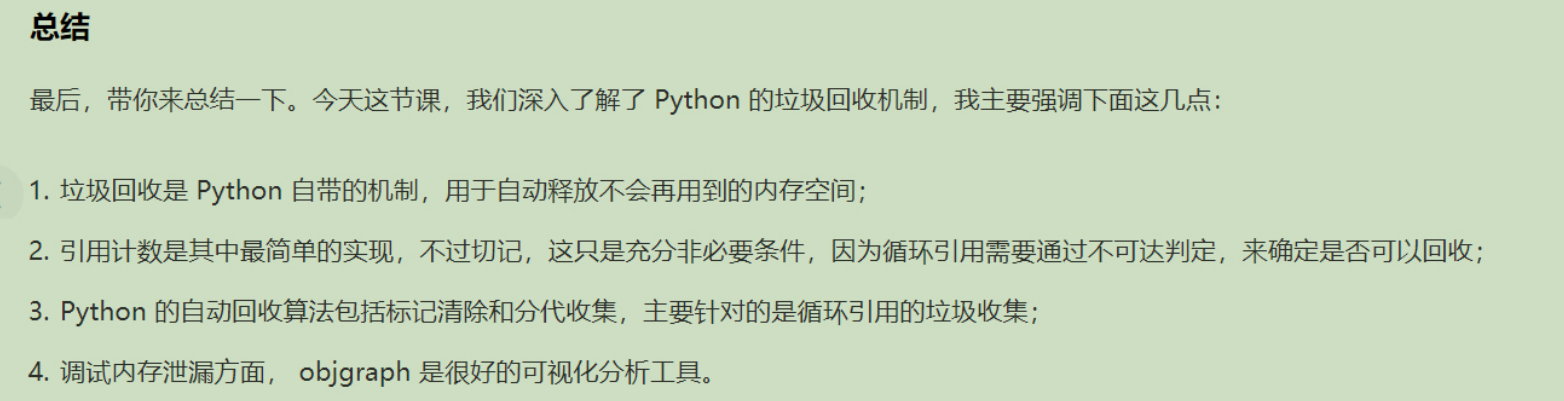